In [69]:
import prunning
import os 
import utils.misc as misc
import utils.visulaiser as visulaiser
import download_datasets_models as dataset
import evaluate_llm as eval
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt


In [40]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
dataloader = dataset.gsm8k


/Users/varunmoparthi/pytorch-test/env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [41]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [14]:
dataset.gsm8k['test']

Dataset({
    features: ['question', 'answer'],
    num_rows: 1319
})

In [15]:
misc.get_model_size(model)/(8 * 1024 * 1024)

474.7001953125

In [16]:
model.named_parameters()

<generator object Module.named_parameters at 0x351701140>

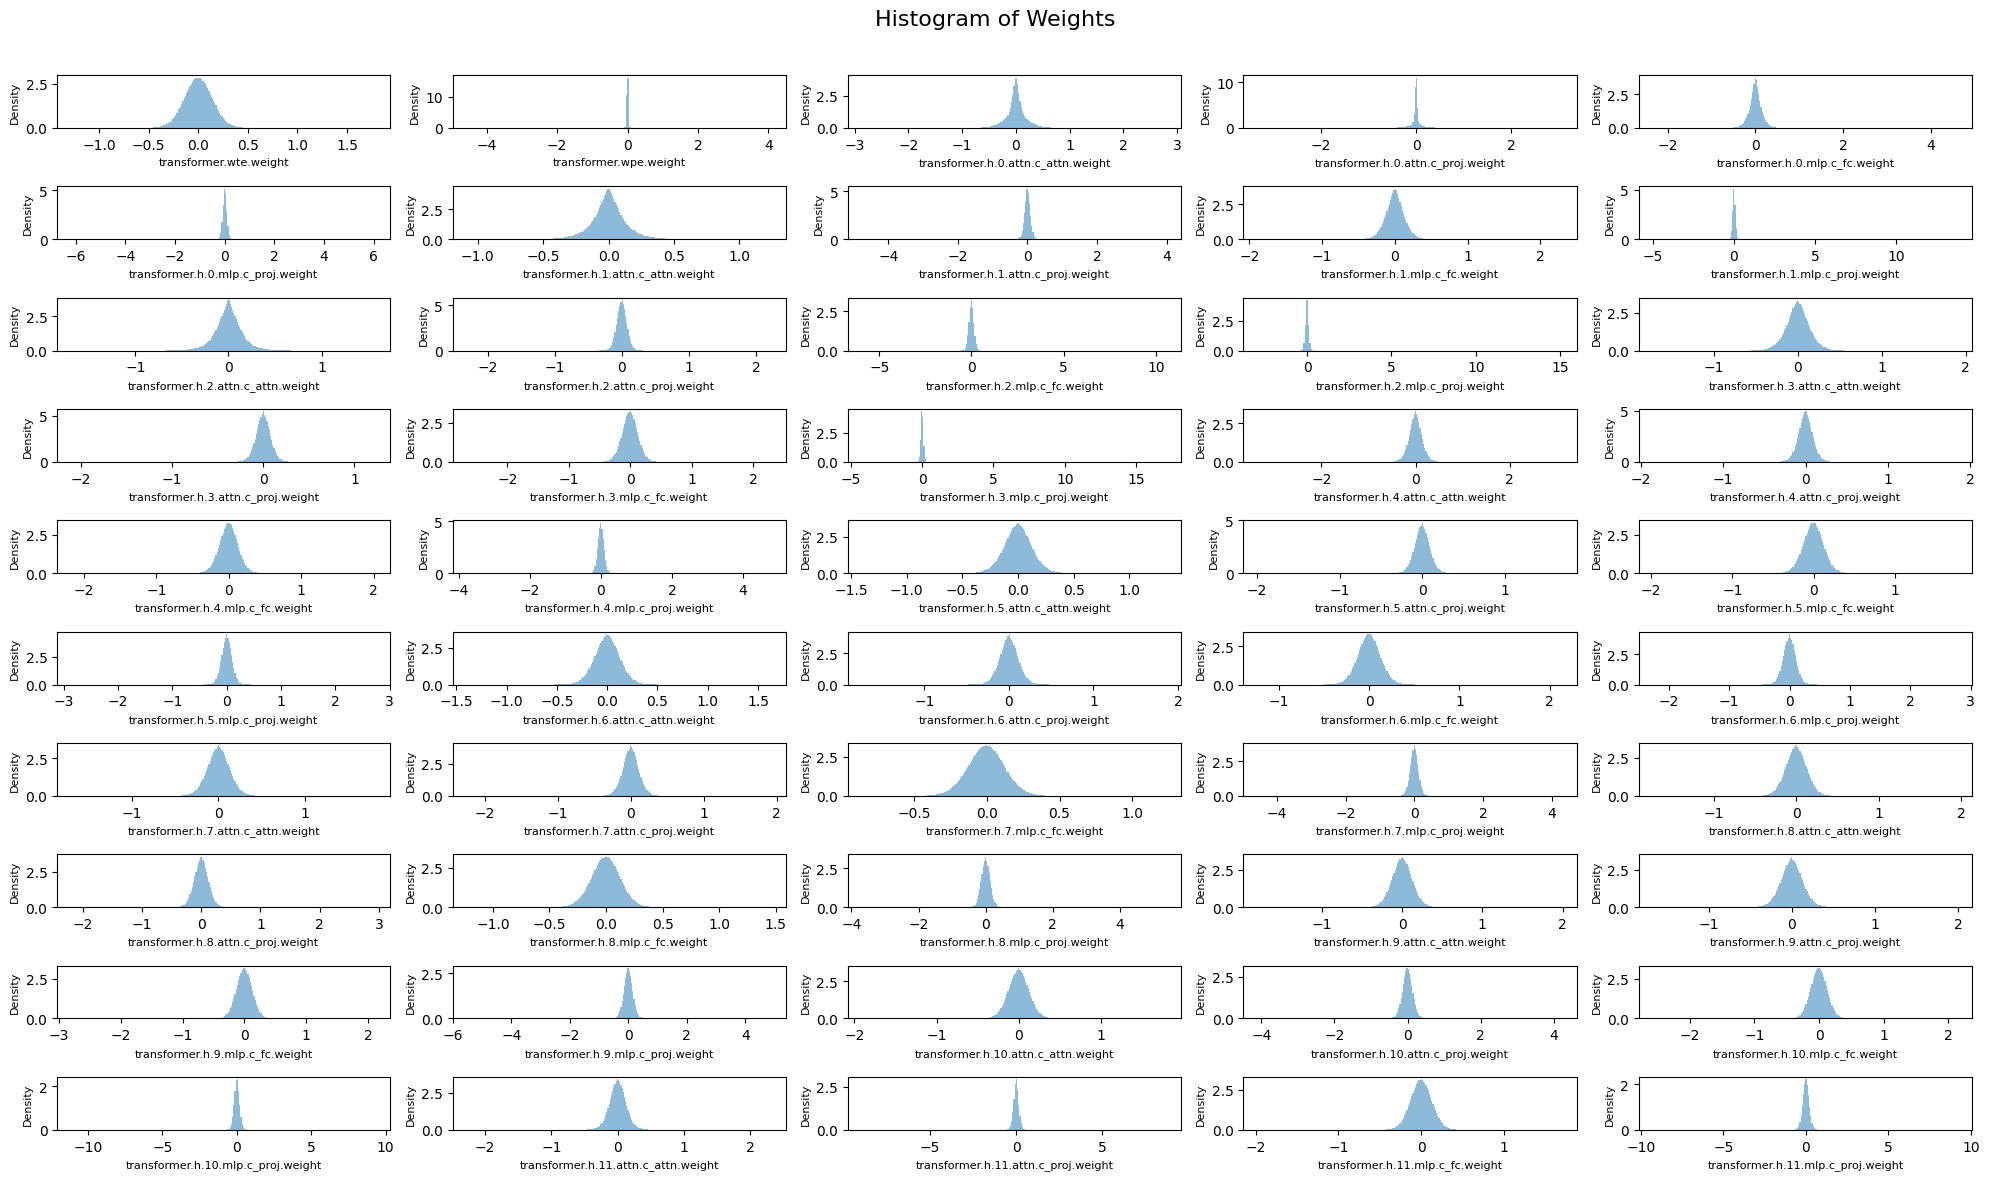

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(10, 5, figsize=(20, 12))  
    axes = axes.ravel()  
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:  
            ax = axes[plot_index]

            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1) 
                ax.hist(param_cpu, bins=bins, density=True, alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, alpha=0.5)
            
            ax.set_xlabel(name, fontsize=8)
            ax.set_ylabel('Density', fontsize=8)
            plot_index += 1
    fig.suptitle('Histogram of Weights', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)  
    plt.show()
    
plot_weight_distribution(model, bins=256, count_nonzero_only=False)


In [65]:
def get_layer_norm(model):
    norms = []
    nLayers = len(model.transformer.h)
    
    for i in range(nLayers):
        layer_norm = 0
        for name, param in model.transformer.h[i].attn.named_parameters():
            if "weight" in name: 
                layer_norm += torch.linalg.matrix_norm(param, ord='fro') 

        norms.append((i, layer_norm.item()))
    return sorted(norms, key=lambda x: x[1])

def get_pruned_model(model, num_layers_to_prune=5):
    model_pruned = copy.deepcopy(model)
    layer_norms = get_layer_norm(model)
    layers_to_prune = [idx for idx, _ in layer_norms[:num_layers_to_prune]]
    print(f"Layers to be pruned (smallest L2 norms): {layers_to_prune}")

    new_layers = torch.nn.ModuleList(
        [layer for i, layer in enumerate(model.transformer.h) if i not in layers_to_prune]
    )
    
    model_pruned.transformer.h = new_layers

    return model_pruned

pruned_model = get_pruned_model(model, num_layers_to_prune=3)

print(f"Original number of layers: {len(model.transformer.h)}")
print(f"Pruned number of layers: {len(pruned_model.transformer.h)}")


Layers to be pruned (smallest L2 norms): [2, 1, 5]
Original number of layers: 12
Pruned number of layers: 9


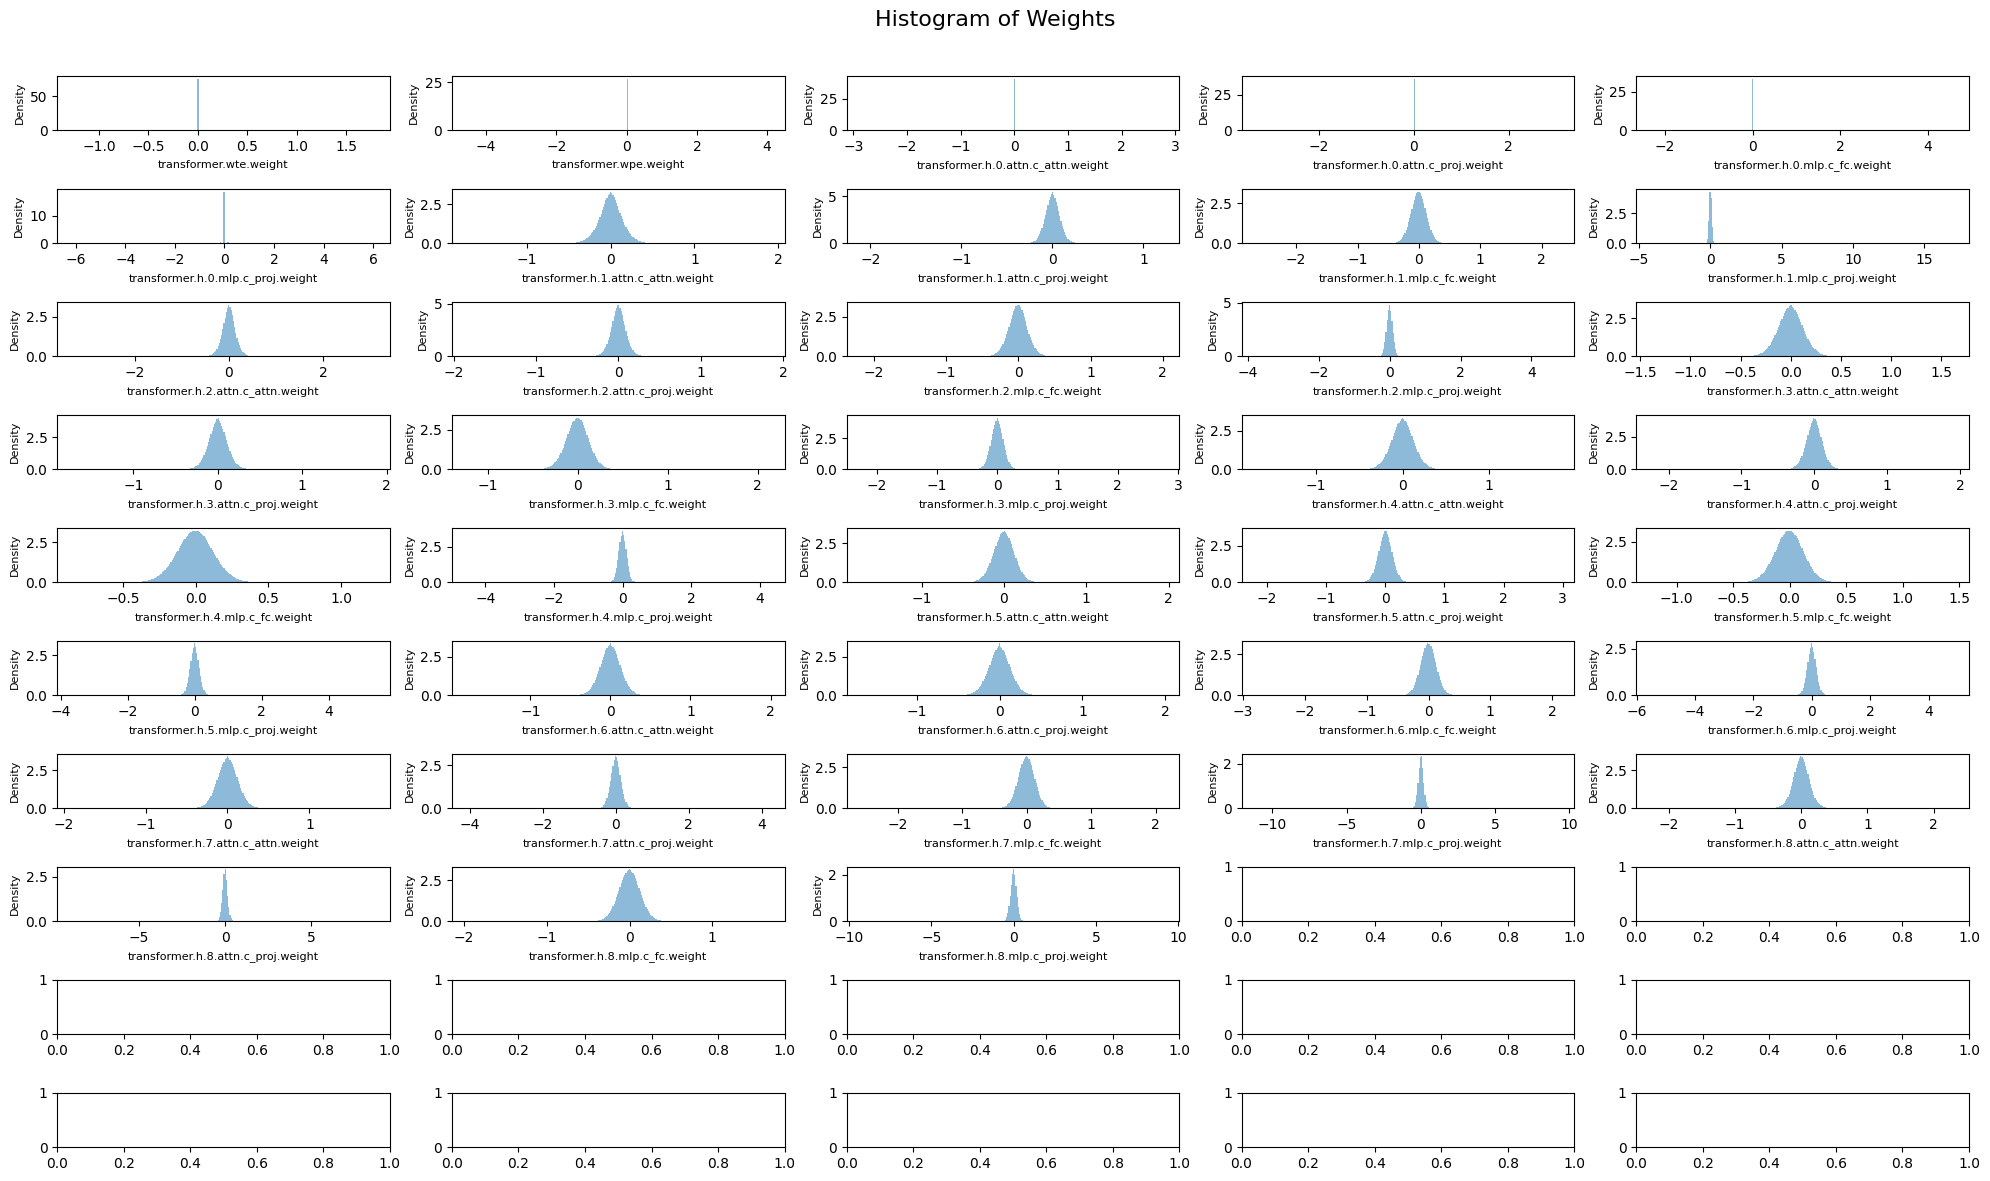

In [66]:
plot_weight_distribution(pruned_model, bins=256, count_nonzero_only=False)


In [62]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [61]:
model_pruned = get_pruned_model(model)

AttributeError: 'GPT2LMHeadModel' object has no attribute 'model'

In [78]:

from datasets import load_dataset, load_from_disk


def print_model_predictions(model, tokenizer, dataset, device="cpu", num_samples=5):
    model.to(device)
    model.eval()
    dataset = load_from_disk(dataset)
    dataset = dataset['test']
    
    for i in range(min(num_samples, len(dataset))):
        example = dataset[i]
        input_text = example["question"]
        target_output = example["answer"]
        
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_length=256)
        generated_answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        print(f"Example {i+1}:\n")
        print(f"Input: {input_text}\n")
        print(f"Generated Answer: {generated_answer}\n")
        print(f"Target Output: {target_output}\n")
        print("-" * 50)
        if i == 20:
            break


In [79]:
print_model_predictions(model, tokenizer, './gsm8k_saved', 'cpu')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Example 1:

Input: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Generated Answer: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market? " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz " " " " " " " " " " " " " " Citiz and Citiz and Citiz and 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Example 2:

Input: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?

Generated Answer: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take? " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " ", a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Target Output: It takes 2/2=<<2/2=1>>1 bolt of white fiber
So the total amount of fabric is 2+1=<<2+1=3>>3 bolts of fabric
#### 3

--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Example 3:

Input: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?

Generated Answer: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? " " " " " " " " " " " " " " " " " " " " " " " " " " " " " ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,, wonder, wonder wonder wonder wonder wonder wonder wonder wonder a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz hire Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz Citiz C

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Example 4:

Input: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?

Generated Answer: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week? " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " ",,,,,,,,,,,,,,,,, a a a a a herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself

In [70]:
model_accuracy = eval.measure_test_accuracy(model, tokenizer, './gsm8k_saved', 'cpu')

Len of Test Data:  1319
Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1172
Average ROUGE-2: 0.0486
Average ROUGE-L: 0.0828


In [43]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    importance = torch.abs(tensor)
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    mask = importance > threshold

    tensor.mul_(mask)

    return mask

In [56]:
def sensitivity_scan(model, tokenizer, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) in model.named_parameters() if param.dim() > 1]
    print(sparsities)
    
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'Scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = eval.measure_test_accuracy(model, tokenizer, './gsm8k_saved', 'cpu')
            
            # Check if the accuracy is None before formatting
            if acc is not None:
                print(f'sparsity={sparsity}: accuracy={acc}%', end='')
                accuracy.append(acc)
            else:
                print(f'sparsity={sparsity}: accuracy=NA (None received)', end='')
            
            param_clone = param.detach().clone()
            param.data.copy_(param_clone)
        
        # After finishing a layer scan, print the full sparsity-accuracy report for that layer
        if accuracy:
            print(f'sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        else:
            print(f'No valid accuracy recorded for layer {name}')
        
        accuracies.append(accuracy)
    
    return sparsities, accuracies


In [57]:
sparsities, accuracies = sensitivity_scan(model, tokenizer, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

[0.4 0.5 0.6 0.7 0.8 0.9]


Scanning 0/50 weight - transformer.wte.weight:   0%|                                                                               | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 0/50 weight - transformer.wte.weight:  17%|███████████▊                                                           | 1/6 [00:09<00:46,  9.34s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1491
Average ROUGE-2: 0.0619
Average ROUGE-L: 0.1053
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 0/50 weight - transformer.wte.weight:  33%|███████████████████████▋                                               | 2/6 [00:19<00:38,  9.56s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1214
Average ROUGE-2: 0.0504
Average ROUGE-L: 0.1071
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 0/50 weight - transformer.wte.weight:  50%|███████████████████████████████████▌                                   | 3/6 [00:29<00:29,  9.87s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1502
Average ROUGE-2: 0.0664
Average ROUGE-L: 0.1127
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 0/50 weight - transformer.wte.weight:  67%|███████████████████████████████████████████████▎                       | 4/6 [00:39<00:19,  9.87s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 0/50 weight - transformer.wte.weight:  83%|███████████████████████████████████████████████████████████▏           | 5/6 [00:48<00:09,  9.84s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0985
Average ROUGE-2: 0.0433
Average ROUGE-L: 0.0738
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 0/50 weight - transformer.wte.weight: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.68s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0941
Average ROUGE-2: 0.0414
Average ROUGE-L: 0.0706
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.wte.weight


Scanning 1/50 weight - transformer.wpe.weight:   0%|                                                                               | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 1/50 weight - transformer.wpe.weight:  17%|███████████▊                                                           | 1/6 [00:08<00:42,  8.44s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0941
Average ROUGE-2: 0.0414
Average ROUGE-L: 0.0706
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 1/50 weight - transformer.wpe.weight:  33%|███████████████████████▋                                               | 2/6 [00:18<00:37,  9.27s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0941
Average ROUGE-2: 0.0414
Average ROUGE-L: 0.0706
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 1/50 weight - transformer.wpe.weight:  50%|███████████████████████████████████▌                                   | 3/6 [00:28<00:28,  9.64s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0941
Average ROUGE-2: 0.0414
Average ROUGE-L: 0.0706
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 1/50 weight - transformer.wpe.weight:  67%|███████████████████████████████████████████████▎                       | 4/6 [00:38<00:19,  9.68s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0941
Average ROUGE-2: 0.0414
Average ROUGE-L: 0.0706
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 1/50 weight - transformer.wpe.weight:  83%|███████████████████████████████████████████████████████████▏           | 5/6 [00:48<00:09,  9.79s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0941
Average ROUGE-2: 0.0414
Average ROUGE-L: 0.0706
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 1/50 weight - transformer.wpe.weight: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [01:02<00:00, 10.34s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0950
Average ROUGE-2: 0.0418
Average ROUGE-L: 0.0712
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.wpe.weight


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight:   0%|                                                                   | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight:  17%|█████████▊                                                 | 1/6 [00:09<00:49,  9.99s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.2105
Average ROUGE-2: 0.0933
Average ROUGE-L: 0.1579
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight:  33%|███████████████████▋                                       | 2/6 [00:19<00:38,  9.52s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1115
Average ROUGE-2: 0.0491
Average ROUGE-L: 0.0836
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight:  50%|█████████████████████████████▌                             | 3/6 [00:27<00:26,  8.81s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight:  67%|███████████████████████████████████████▎                   | 4/6 [00:34<00:16,  8.41s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight:  83%|█████████████████████████████████████████████████▏         | 5/6 [00:42<00:08,  8.19s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3200
Average ROUGE-2: 0.1429
Average ROUGE-L: 0.2400
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 2/50 weight - transformer.h.0.attn.c_attn.weight: 100%|███████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.54s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1693
Average ROUGE-2: 0.0749
Average ROUGE-L: 0.1270
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.0.attn.c_attn.weight


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight:   0%|                                                                   | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight:  17%|█████████▊                                                 | 1/6 [00:08<00:40,  8.13s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1768
Average ROUGE-2: 0.0782
Average ROUGE-L: 0.1326
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight:  33%|███████████████████▋                                       | 2/6 [00:15<00:31,  7.93s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1749
Average ROUGE-2: 0.0773
Average ROUGE-L: 0.1311
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight:  50%|█████████████████████████████▌                             | 3/6 [00:23<00:23,  7.90s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1410
Average ROUGE-2: 0.0622
Average ROUGE-L: 0.1057
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight:  67%|███████████████████████████████████████▎                   | 4/6 [00:32<00:16,  8.18s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1270
Average ROUGE-2: 0.0560
Average ROUGE-L: 0.0952
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight:  83%|█████████████████████████████████████████████████▏         | 5/6 [00:40<00:08,  8.09s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0964
Average ROUGE-2: 0.0424
Average ROUGE-L: 0.0723
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 3/50 weight - transformer.h.0.attn.c_proj.weight: 100%|███████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.00s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1009
Average ROUGE-2: 0.0418
Average ROUGE-L: 0.0712
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.0.attn.c_proj.weight


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight:   0%|                                                                      | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight:  17%|██████████▎                                                   | 1/6 [00:08<00:41,  8.28s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0944
Average ROUGE-2: 0.0415
Average ROUGE-L: 0.0708
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight:  33%|████████████████████▋                                         | 2/6 [00:16<00:32,  8.23s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1546
Average ROUGE-2: 0.0683
Average ROUGE-L: 0.1159
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight:  50%|███████████████████████████████                               | 3/6 [00:24<00:24,  8.13s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight:  67%|█████████████████████████████████████████▎                    | 4/6 [00:32<00:16,  8.10s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight:  83%|███████████████████████████████████████████████████▋          | 5/6 [00:40<00:08,  8.18s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.2909
Average ROUGE-2: 0.1296
Average ROUGE-L: 0.2182
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 4/50 weight - transformer.h.0.mlp.c_fc.weight: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.15s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.0.mlp.c_fc.weight


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight:  17%|██████████                                                  | 1/6 [00:08<00:40,  8.14s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight:  33%|████████████████████                                        | 2/6 [00:16<00:32,  8.10s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight:  50%|██████████████████████████████                              | 3/6 [00:23<00:23,  7.94s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight:  67%|████████████████████████████████████████                    | 4/6 [00:31<00:15,  7.96s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1608
Average ROUGE-2: 0.0711
Average ROUGE-L: 0.1206
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight:  83%|██████████████████████████████████████████████████          | 5/6 [00:40<00:08,  8.24s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 5/50 weight - transformer.h.0.mlp.c_proj.weight: 100%|████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.11s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1115
Average ROUGE-2: 0.0462
Average ROUGE-L: 0.0787
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.0.mlp.c_proj.weight


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight:   0%|                                                                   | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight:  17%|█████████▊                                                 | 1/6 [00:08<00:41,  8.30s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1860
Average ROUGE-2: 0.0824
Average ROUGE-L: 0.1395
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight:  33%|███████████████████▋                                       | 2/6 [00:16<00:33,  8.30s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1362
Average ROUGE-2: 0.0601
Average ROUGE-L: 0.1021
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight:  50%|█████████████████████████████▌                             | 3/6 [00:24<00:24,  8.32s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3265
Average ROUGE-2: 0.1458
Average ROUGE-L: 0.2449
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight:  67%|███████████████████████████████████████▎                   | 4/6 [00:32<00:16,  8.13s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.2148
Average ROUGE-2: 0.0952
Average ROUGE-L: 0.1611
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight:  83%|█████████████████████████████████████████████████▏         | 5/6 [00:40<00:07,  7.94s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1916
Average ROUGE-2: 0.0848
Average ROUGE-L: 0.1437
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 6/50 weight - transformer.h.1.attn.c_attn.weight: 100%|███████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.03s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1255
Average ROUGE-2: 0.0553
Average ROUGE-L: 0.0941
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.1.attn.c_attn.weight


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight:   0%|                                                                   | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight:  17%|█████████▊                                                 | 1/6 [00:10<00:50, 10.13s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1524
Average ROUGE-2: 0.0673
Average ROUGE-L: 0.1143
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight:  33%|███████████████████▋                                       | 2/6 [00:20<00:42, 10.55s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1468
Average ROUGE-2: 0.0648
Average ROUGE-L: 0.1101
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight:  50%|█████████████████████████████▌                             | 3/6 [00:30<00:29,  9.88s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1273
Average ROUGE-2: 0.0528
Average ROUGE-L: 0.0899
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight:  67%|███████████████████████████████████████▎                   | 4/6 [00:39<00:19,  9.85s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1189
Average ROUGE-2: 0.0493
Average ROUGE-L: 0.0839
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight:  83%|█████████████████████████████████████████████████▏         | 5/6 [00:50<00:10, 10.11s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1350
Average ROUGE-2: 0.0596
Average ROUGE-L: 0.1013
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 7/50 weight - transformer.h.1.attn.c_proj.weight: 100%|███████████████████████████████████████████████████████████| 6/6 [01:00<00:00, 10.07s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.2581
Average ROUGE-2: 0.1148
Average ROUGE-L: 0.1935
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.1.attn.c_proj.weight


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight:   0%|                                                                      | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight:  17%|██████████▎                                                   | 1/6 [00:09<00:46,  9.28s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1349
Average ROUGE-2: 0.0560
Average ROUGE-L: 0.0952
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight:  33%|████████████████████▋                                         | 2/6 [00:19<00:39,  9.80s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1189
Average ROUGE-2: 0.0493
Average ROUGE-L: 0.0839
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight:  50%|███████████████████████████████                               | 3/6 [00:30<00:30, 10.18s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.2500
Average ROUGE-2: 0.1045
Average ROUGE-L: 0.1765
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight:  67%|█████████████████████████████████████████▎                    | 4/6 [00:39<00:19,  9.98s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight:  83%|███████████████████████████████████████████████████▋          | 5/6 [00:49<00:10, 10.03s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.2411
Average ROUGE-2: 0.1007
Average ROUGE-L: 0.1702
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 8/50 weight - transformer.h.1.mlp.c_fc.weight: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.80s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1382
Average ROUGE-2: 0.0574
Average ROUGE-L: 0.0976
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.1.mlp.c_fc.weight


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight:  17%|██████████                                                  | 1/6 [00:08<00:43,  8.69s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1453
Average ROUGE-2: 0.0603
Average ROUGE-L: 0.1026
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight:  33%|████████████████████                                        | 2/6 [00:16<00:32,  8.16s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1650
Average ROUGE-2: 0.0686
Average ROUGE-L: 0.1165
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight:  50%|██████████████████████████████                              | 3/6 [00:25<00:26,  8.70s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3333
Average ROUGE-2: 0.1400
Average ROUGE-L: 0.2353
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight:  67%|████████████████████████████████████████                    | 4/6 [00:35<00:18,  9.07s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3168
Average ROUGE-2: 0.1414
Average ROUGE-L: 0.2376
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight:  83%|██████████████████████████████████████████████████          | 5/6 [00:43<00:08,  8.62s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3636
Average ROUGE-2: 0.1628
Average ROUGE-L: 0.2727
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 9/50 weight - transformer.h.1.mlp.c_proj.weight: 100%|████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.52s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.1.mlp.c_proj.weight


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight:   0%|                                                                  | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight:  17%|█████████▋                                                | 1/6 [00:07<00:39,  7.92s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight:  33%|███████████████████▎                                      | 2/6 [00:16<00:32,  8.03s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1839
Average ROUGE-2: 0.0814
Average ROUGE-L: 0.1379
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight:  50%|█████████████████████████████                             | 3/6 [00:23<00:24,  8.00s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1435
Average ROUGE-2: 0.0596
Average ROUGE-L: 0.1013
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight:  67%|██████████████████████████████████████▋                   | 4/6 [00:35<00:18,  9.46s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight:  83%|████████████████████████████████████████████████▎         | 5/6 [00:46<00:09,  9.86s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 10/50 weight - transformer.h.2.attn.c_attn.weight: 100%|██████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0938
Average ROUGE-2: 0.0413
Average ROUGE-L: 0.0704
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.2.attn.c_attn.weight


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight:   0%|                                                                  | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight:  17%|█████████▋                                                | 1/6 [00:09<00:45,  9.17s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1193
Average ROUGE-2: 0.0495
Average ROUGE-L: 0.0842
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight:  33%|███████████████████▎                                      | 2/6 [00:19<00:38,  9.57s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0997
Average ROUGE-2: 0.0413
Average ROUGE-L: 0.0704
sparsity=0.5: accuracy=NA (None received)Len of Test Data:  1319


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight:  50%|█████████████████████████████                             | 3/6 [00:30<00:30, 10.26s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.0938
Average ROUGE-2: 0.0413
Average ROUGE-L: 0.0704
sparsity=0.6: accuracy=NA (None received)Len of Test Data:  1319


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight:  67%|██████████████████████████████████████▋                   | 4/6 [00:39<00:20, 10.10s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.7: accuracy=NA (None received)Len of Test Data:  1319


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight:  83%|████████████████████████████████████████████████▎         | 5/6 [00:49<00:09,  9.91s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1356
Average ROUGE-2: 0.0598
Average ROUGE-L: 0.1017
sparsity=0.7999999999999999: accuracy=NA (None received)Len of Test Data:  1319


Scanning 11/50 weight - transformer.h.2.attn.c_proj.weight: 100%|██████████████████████████████████████████████████████████| 6/6 [01:00<00:00, 10.02s/it]


Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.3765
Average ROUGE-2: 0.1687
Average ROUGE-L: 0.2824
sparsity=0.8999999999999999: accuracy=NA (None received)No valid accuracy recorded for layer transformer.h.2.attn.c_proj.weight


Scanning 12/50 weight - transformer.h.2.mlp.c_fc.weight:   0%|                                                                     | 0/6 [00:00<?, ?it/s]

Len of Test Data:  1319


Scanning 12/50 weight - transformer.h.2.mlp.c_fc.weight:  17%|██████████▏                                                  | 1/6 [00:11<00:58, 11.63s/it]

Model Accuracy on GSM8K: 0.00%
Average ROUGE-1: 0.1164
Average ROUGE-2: 0.0483
Average ROUGE-L: 0.0822
sparsity=0.4: accuracy=NA (None received)Len of Test Data:  1319


Scanning 12/50 weight - transformer.h.2.mlp.c_fc.weight:  17%|██████████▏                                                  | 1/6 [00:12<01:01, 12.24s/it]


KeyboardInterrupt: 

In [ ]:
dict = {
    "layer_name": "" ## Ratio depending on scan graph
}

In [ ]:
pruner = prunning.FineGrainedPruner(model, dict)
sparse_model_size = misc.get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size /(8*1024*1024):.2f} MiB = {sparse_model_size / misc.get_model_size(model) * 100:.2f}% of dense model size")
sparse_model_accuracy = misc.evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")